# Homework 2 from Martin Gräf, Richard Baumann and Thomas Block

## Exercise 1

After taking a look at the one-dimensional ising model in Homework 1, we now take a look at the two-dimensional variant. Again we have the hamiltonian:


\begin{equation}
    H(\sigma) = - J \sum_{\langle x~y\rangle} \sigma_x \sigma_y - h \sum_x \sigma_x
\end{equation}





In [1]:
#just importing stuff, nothing to see here yet :)

import numpy as np 
import random as rd
import matplotlib.pyplot as plt
import math
import itertools 

This time we not only look at the particles left and right of the observed particle, but at the particles above and below. Therefore the hamiltonian looks like this:

\begin{equation}
    H(\sigma) = - J (\sigma_{x-1, y} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x1, y} + \sigma_{x, y-1} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x, y}) - h \sigma_{x, y}
\end{equation}

As we can see in the equation above, this hamiltonian looks at all adjacent spins. Therefore, the implementation looks something like that:


In [2]:
#Spin is supposed to be a NxN big array. Position has to be an array of the form [x, y] to indicate the position of the spin.
def hamiltionian(spin_array, position, j, h):
    minuend = 0
    for i in [-1, 1]:
        #if we hit the right side, go to the left side
        if position[0]+i>len(spin_array[0])-1:
            #print("i was", i, "which would result in", position[0]+i, "therefore it is now changed to", position[0]-position[0])
            i=-position[0]
        #if we hit the left side, go to the right side
        elif position[0]+i<0:
            #print("i was", i, "which would result in", position[0]+i, "therefore it is now changed to", position[0]+len(spin_array[0])-1)
            i=len(spin_array[0])-1
        #Left/right spin
        minuend = minuend + spin_array[position[0]+i][position[1]]*spin_array[position[0]][position[1]]
    for i in [-1, 1]:
        #if we hit the top, go to the bottom side
        if position[1]+i>len(spin_array[0])-1:
            #print("i was", i, "which would result in", position[0]+i, "therefore it is now changed to", position[1]-position[1])
            i=-position[1]
        #if we hit the bottom, go to the top side
        elif position[1]+i<0:
            #print("i was", i, "which would result in", position[0]+i, "therefore it is now changed to", position[1]+len(spin_array[0])-1)
            i=len(spin_array[0])-1
        #Lower/upper spin
        minuend = minuend + spin_array[position[0]][position[1]+i]*spin_array[position[0]][position[1]] 
    return (-j*minuend-h*spin_array[position[0]][position[1]])

Now we have to generate a spin array, that can be used later on. This array has to be two dimensional. This spin-arry is $ N_{x} $ x $ N_{y} $ large, however in accordance to the exercise sheet we choose $ N_{x}=N_{y} $.

In [3]:
def gen_spin_array(length):
    configurations=[]
    current_configuration=[]
    for j in range(length):
        for i in range(length):
            #a random integer between 1 and 3 (1, 2)
            current_configuration=current_configuration+[2*rd.randint(1, 2)-3]
        configurations=configurations+[current_configuration]
        current_configuration=[]
    return configurations

We can carry over the other instructions from the previous homework. Therefore, we assume, that the spins are distributed following a Bolzmann distribution (a fact, that is given by the exercise sheet):

\begin{equation}
    P(s)=\frac{ exp \big[-\frac{H(s)}{k_{b}T} \big]}{\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]}  = \frac{1}{Z} exp \big[-\frac{H(s)}{k_{b}T} \big].
\end{equation}

Thus, Z can be determined via:

\begin{equation}
    Z={\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]} 
\end{equation}

In [4]:
def z_simulated(spin_array, j, h, t):
    sum=0
    for l in range(len(spin_array[0])):
        for k in range(len(spin_array[0])):
            sum=sum+np.exp(-hamiltionian(spin_array, [l, k], j, h)/t)
    return (sum)

And, the magnetization per spin is defined as:

\begin{equation}
    <m>=+\frac{T}{N}\frac{\partial log(Z)}{\partial h} 
\end{equation}

In [5]:
def magnetization_random_configurations(spin_array, j, h, t, intervall):
    z_1=z_simulated(spin_array, j, h+(intervall/2), t)
    z_2=z_simulated(spin_array, j, h-(intervall/2), t)
    return (t/(len(spin_array[0])**2)*((np.log(z_1)-np.log(z_2))/intervall))

#Todo Format this better with markdown. The desired Format ist in Lecture 3 Slide 55

Here comes the part that is different to the last homework. Instead of brute forcing the solution we now have a plan. We will use the Metropolis-Hastings Method:

1. We take a random spin from our matrix
2. Then we flip the spin ($s_{i}=-1*s_{i}$)
3. The change in energy is calculated
4. Actual Metropolis-Hastings step:
    *A if $\Delta S < 0 $ ACCEPT the spin flip
    *B else sample > ~ U(0,1)
        if y $\leq exp(-\Delta S)$ ACCEPT the spin flip
        otherwise REJECT the spin flip and keep the original spin s_{i}
5. Steps 1-4 are repeated for $\Lambda$ times (which is called sweep)

First we will implement a sweep:

In [6]:
def sweep(spin_array, j, h, t):
    position=[rd.randint(0, len(spin_array)-1), rd.randint(0, len(spin_array)-1)]
    position=[1, 1]
    #Calculate Energy prior to flip
    s_prior=hamiltionian(spin_array, position, j, h)/t
    #Flip Spin
    spin_array[position[0]][position[1]]=-spin_array[position[0]][position[1]]
    #Calculate Energy after flip
    s_later=hamiltionian(spin_array, position, j, h)/t
    #Computing the Energy
    delta_s=s_later-s_prior
    if delta_s>0:
        y=rd.randint(0, 1)
        if y>math.exp(-delta_s):
            spin_array[position[0]][position[1]]=-spin_array[position[0]][position[1]]
    return(spin_array)


Now these sweeps are executed a lot of times. The next steps are:

6. Measure the a relevant property (magnetization, internal energy, etc.)
7. Repeat from step 1 (Over time magnetization should converge towards the real value of the observable)

In [26]:
#lambda seems to cause a invalid syntax error 
def mc_estimate(spin_array, j, h, t, lamba, repeats):
    m=np.zeros(repeats)
    for k in range(repeats):
        for i in range(lamba):
            spin_array=sweep(spin_array, j, h, t)
        m[k]=magnetization_random_configurations(spin_array, j, h, t, 0.1)
    return np.average(m)

## Exercise 2

Todo: How does the numerical cost of the calculation of the energy (for a given spin configuration) scale with the system size $\Lambda$ ? 

## Exercise 3

Todo: Assuming you’ve flipped one spin $s_{i}$, how does the numerical cost of the calculation of the change in energy $\Delta S$ scale with the system size $\Lambda$ ?

## Exercise 4

Todo: What is the significance of the critical coupling $J_c$ ?

## Exercise 5

Now we can look at how the magnetization changes when the relevant parameters change. First we look at the value of m with different N values.

$N \in [4, 20]$

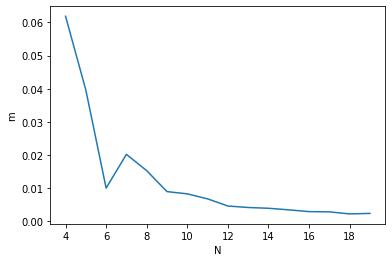

In [28]:
def plot_m_N_dependency(min_value, max_value, j, h, t, lamba, repeats):
    n_array=np.arange(min_value, max_value, 1)
    m_array=np.zeros(len(n_array))
    for i in range(len(n_array)):
        m_array[i]=mc_estimate(gen_spin_array(n_array[i]), j, h, t, lamba, repeats)
    plt.plot(n_array, m_array)
    plt.xlabel("N")
    plt.ylabel("m")
    plt.savefig("n_m_dependency.png")

plot_m_N_dependency(4, 20, 1, 1, 1, 100, 100)

Now we can look at how the magnetization changes with changing h values.

$h \in [-1, 1]$

In [ ]:
def plot_m_N_dependency(min_value, max_value, j, h, t, lamba, repeats):
    n_array=np.arange(min_value, max_value, 1)
    m_array=np.zeros(len(n_array))
    for i in range(len(n_array)):
        m_array[i]=mc_estimate(gen_spin_array(n_array[i]), j, h, t, lamba, repeats)
    plt.plot(n_array, m_array)
    plt.xlabel("N")
    plt.ylabel("m")
    plt.savefig("n_m_dependency.png")

plot_m_N_dependency(4, 20, 1, 1, 1, 100, 100)

## Exercise 6

Use your algorithm to estimate $<\epsilon>$

## Exercise 7

Use your algorithm to estimate 〈|m|〉